In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Image

In [ ]:
from google.colab import files
files.upload()

Saving magic04.data to magic04.data


In [ ]:
names = np.array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'class'])
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names

NameError: ignored

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == 'h'] = 0

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-1, 1, 61)):
    plt.figure(figsize=(5*4, 2*3))
    for i in range(X1.shape[1]):
        plt.subplot(2, 5, i + 1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

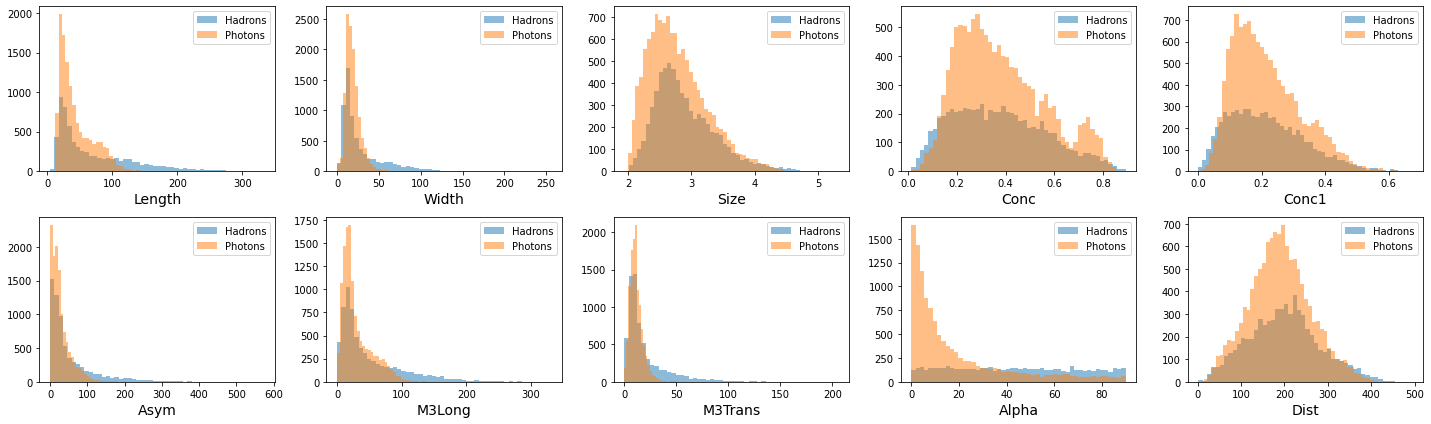

In [ ]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

In [ ]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
X = qt.fit_transform(X)

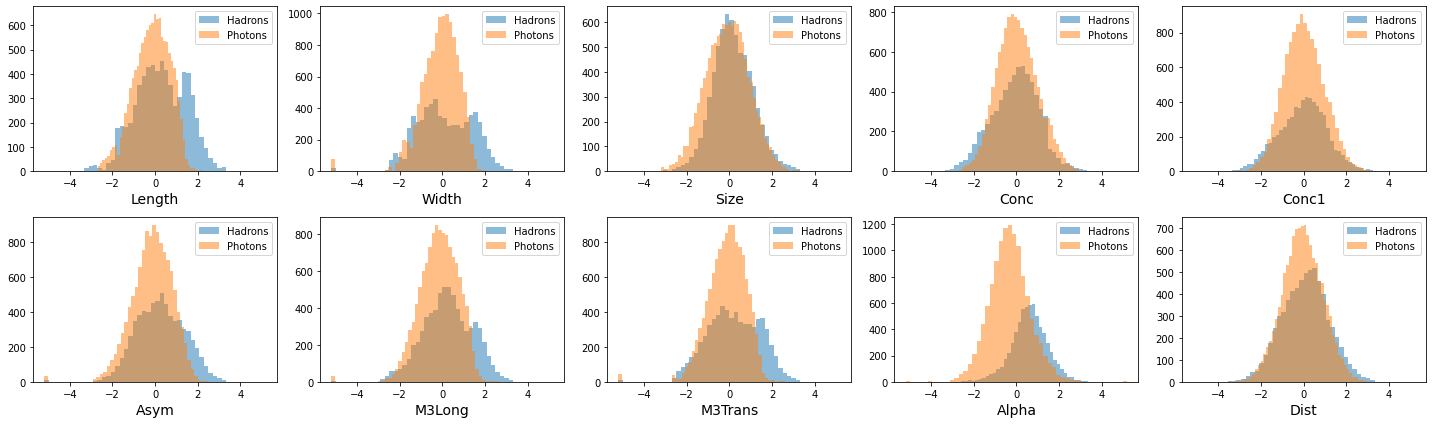

In [ ]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

In [ ]:
from sklearn import preprocessing
import numpy as np

X = preprocessing.normalize(X, axis=0, norm='max')

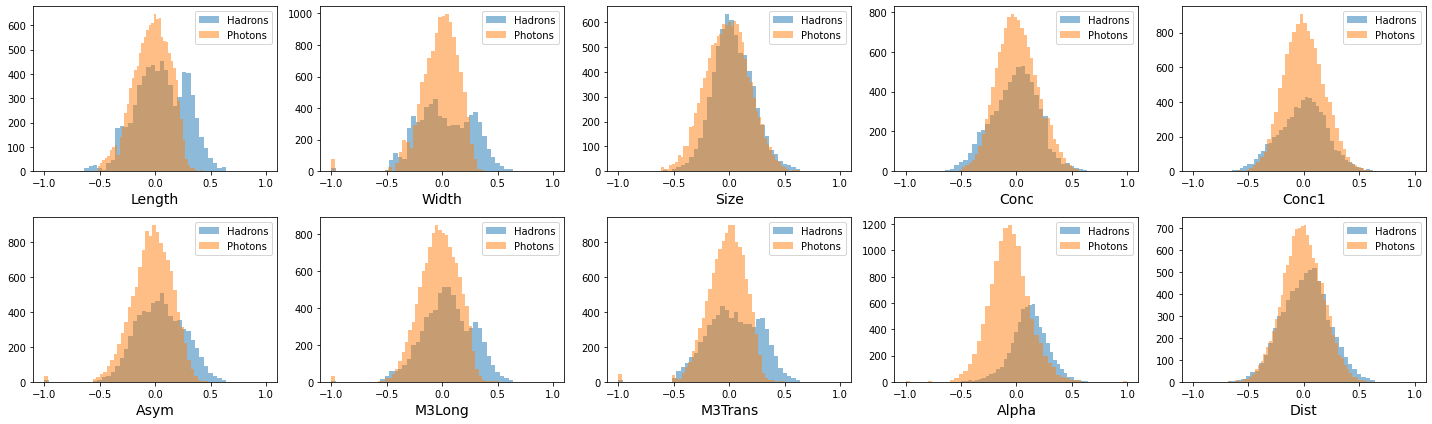

In [ ]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

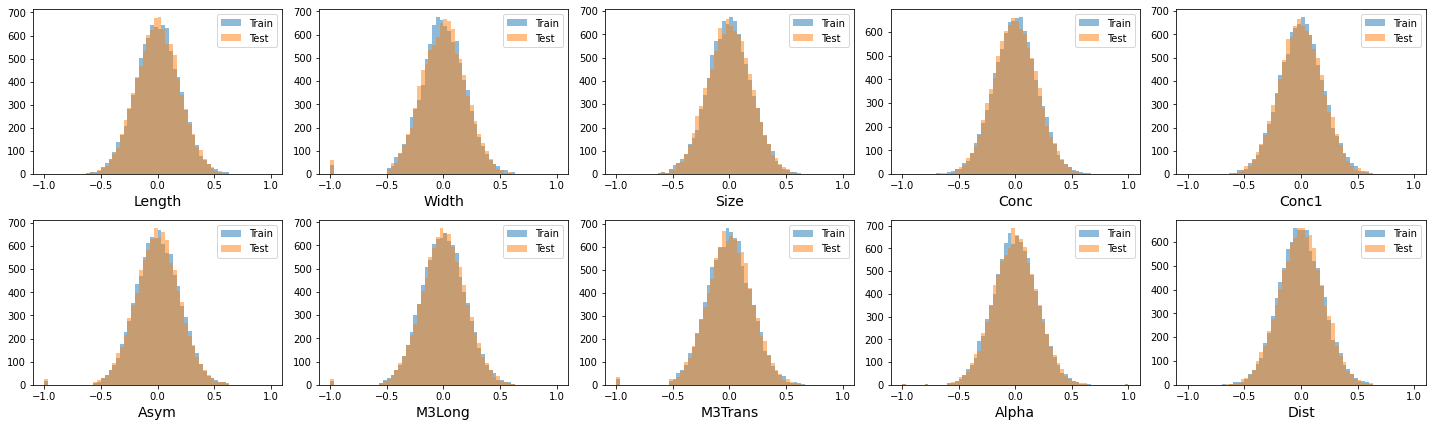

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

In [ ]:
from typing import Optional
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

#device = 'cuda:0'
#torch.cuda.set_device(0)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Generator(nn.Module):
  def __init__(self, lat_size):
    super(Generator, self).__init__()
    self.lat_size = lat_size

    self.label_emb = nn.Embedding(2, 2)

    self.net = nn.Sequential(
        nn.Linear(self.lat_size + 2, 100), nn.ReLU(), nn.BatchNorm1d(100, 0.8),
        nn.Linear(100, 100), nn.ReLU(), nn.BatchNorm1d(100, 0.8),
        nn.Linear(100, 10),
        nn.Tanh())
    
  def forward(self, x, y):
    y = self.label_emb(y.type(torch.IntTensor).to(device))
    xy = torch.cat((x, y), dim=1)
    return self.net(xy)


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.label_emb = nn.Embedding(2, 2)

    self.net = nn.Sequential(
        nn.Linear(10 + 2, 100), nn.LeakyReLU(0.2), nn.BatchNorm1d(100, 0.8),
        nn.Linear(100, 100), nn.LeakyReLU(0.2), nn.BatchNorm1d(100, 0.8),
        nn.Linear(100, 1))


  def forward(self, x, y):
    # клиппинг весов
    for p in self.parameters():
      p.data.clamp_(-0.01, 0.01)
    y = self.label_emb(y.type(torch.IntTensor).to(device))
    xy = torch.cat((x, y), dim=1)
    return self.net(xy).view(-1)

In [ ]:
def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt, prior, 
              num_epochs, gen_steps, discr_steps,
              discr_params_clip_value=None,
              verbose_num_iters=100):

    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # батч реальных объектов
            real_samples, y = batch
            y = y.to(device)
            real_samples = real_samples.to(device)
            batch_size = real_samples.shape[0]

            # таргеты реальных объектов (1) и сгенерированных (0)
            real_samples_labels = torch.ones((batch_size, 1)).to(device)
            gen_samples_labels = torch.zeros((batch_size, 1)).to(device)
            lat_samples_codes = prior.sample((batch_size, ))
            
            # батч сгенерированных объектов
            gen_samples = gen(lat_samples_codes, y)
            # двойной батч на вход дискриминатору и его реальные таргеты (1 и 0)
            all_samples = torch.cat((real_samples, gen_samples), dim=0)
            all_samples_labels = torch.cat((real_samples_labels, gen_samples_labels), dim=0)

            # выходы дискриминатора на двойном батче
            all_samples_output = discr(all_samples, torch.cat((y, y), dim=0))
            real_samples_output, gen_samples_output = torch.split(all_samples_output, batch_size)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
                # генератор учится на gen_samples_output и считает ошибку по real_samples_labels
                gen_opt.zero_grad()
                gen_loss = gen_samples_output.mean(0).view(1)
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # дискриминатор учится на all_samples и считает ошибку по all_samples_labels = real_samples_labels + generated_samples_labels
                discr_opt.zero_grad()
                discr_loss = (real_samples_output - gen_samples_output).mean(0).view(1)
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1
         # Выводим значения функций потерь
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')

                plt.show()

In [ ]:
X_real = torch.tensor(X, dtype=torch.float, device=device)
y_cond = torch.tensor(y.ravel(), dtype=torch.float, device=device)       

dataset_real = TensorDataset(X_real, y_cond)

train_dataloader = DataLoader(dataset_real, batch_size=32, shuffle=True)

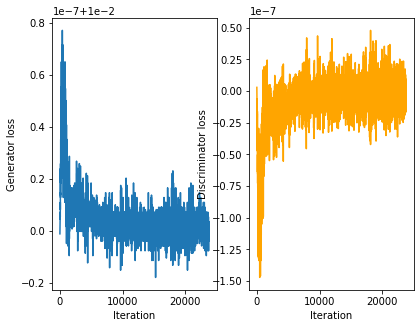

In [ ]:
gen = Generator(10).to(device)
discr = Discriminator().to(device)
prior = torch.distributions.Normal(torch.zeros(10).to(device), torch.ones(10).to(device))

gen_opt = optim.RMSprop(gen.parameters(), lr=3e-4)
discr_opt = optim.RMSprop(discr.parameters(), lr=3e-4) 

train_gan(train_dataloader, gen, 
          discr, gen_opt, discr_opt, prior,
          num_epochs=40, gen_steps=1, discr_steps=3,
          verbose_num_iters=100)

In [ ]:
def generate(generator, y, latent_dim):
    size = y.shape[0]
    y = torch.tensor(y.ravel(), dtype=torch.float, device=device)
    latent_codes = torch.normal(0, 1, (size, latent_dim)).to(device)
    X_fake = generator(latent_codes, y)
    return X_fake

In [ ]:
X_fake_train = generate(gen, y_train, 10)

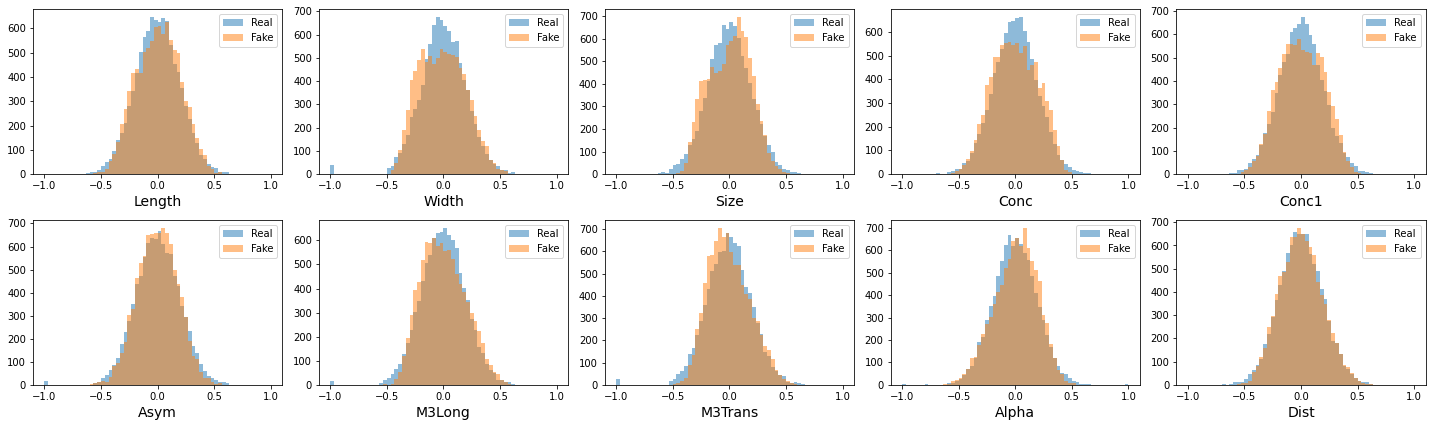

In [ ]:
plot_hists(X_train, X_fake_train.cpu().detach().numpy(), names, label1="Real", label2="Fake")